# Visualizing and analyzing stocks

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import combinations, product
from functools import partial
from multiprocessing import Pool, Manager, cpu_count
from IPython.display import display_html
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

In [2]:
def prep_prices(price):
    
    from decimal import ROUND_HALF_UP, Decimal
    
    pcols = ["Open","High","Low","Close"]

    price.ExpectedDividend.fillna(0,inplace=True)
    
    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))
    
    def adjust_prices(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumAdjust"] = df["AdjustmentFactor"].cumprod()

        # generate adjusted prices
        for p in pcols:     
            df.loc[:, p] = (df["CumAdjust"] * df[p]).apply(qround)
        df.loc[:, "Volume"] = df["Volume"] / df["CumAdjust"]
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        
        #df.loc[:, "Target"] = ((df.Close.shift(-2)/df.Close.shift(-1) - 1)).fillna(df.Target)
        df.Target.fillna(0,inplace=True)

        return df

    # generate Adjusted
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(adjust_prices).reset_index(drop=True)
    price = price.sort_values("RowId")
    return price

In [3]:
path = "../input/jpx-tokyo-stock-exchange-prediction/"

df_train = pd.read_csv(f"{path}train_files/stock_prices.csv", parse_dates=["Date"])
df_train = df_train[df_train.Date>"2020-10-02"] #Targets not Nulls and 2000 secutities data
df_train = prep_prices(df_train)

df_test = pd.read_csv(f"{path}supplemental_files/stock_prices.csv", parse_dates=["Date"])
df_test = prep_prices(df_test)

In [4]:
# create new dataframe with just closing price for each stock
df = df_train.pivot(index='Date', columns='SecuritiesCode', values='Close')
df

SecuritiesCode,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-05,2819.0,453.0,2412.0,2062.0,1615.0,3775.0,2238.0,3330.0,2133.8,1978.0,...,1799.0,66790.0,6750.0,3980.0,4010.0,571.0,951.0,1794.0,2169.0,934.0
2020-10-06,2824.0,450.0,2398.0,2044.0,1588.0,3785.0,2236.0,3355.0,2203.1,1988.0,...,1829.0,66700.0,6913.0,4060.0,3985.0,573.0,952.0,1788.0,2185.0,943.0
2020-10-07,2780.0,446.0,2345.0,2035.0,1541.0,3730.0,2243.0,3300.0,2237.7,1990.0,...,1868.0,66490.0,6955.0,3980.0,3940.0,569.0,932.0,1808.0,2185.0,960.0
2020-10-08,2786.0,443.0,2345.0,2035.0,1502.0,3800.0,2254.0,3250.0,2330.8,1976.0,...,1862.0,67290.0,7085.0,4025.0,4045.0,568.0,944.0,1824.0,2195.0,953.0
2020-10-09,2799.0,436.0,2336.0,2099.0,1510.0,3745.0,2244.0,3300.0,2469.2,1989.0,...,1711.0,69220.0,6997.0,4020.0,4080.0,569.0,934.0,1840.0,2169.0,958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,2951.0,567.0,2269.0,1248.0,1381.0,3125.0,1889.0,3160.0,6430.0,2126.0,...,1725.0,70500.0,6208.0,3070.0,3055.0,528.0,773.0,1680.0,2358.0,668.0
2021-11-30,2900.0,573.0,2277.0,1217.0,1348.0,3125.0,1842.0,3135.0,6550.0,2118.0,...,1690.0,67400.0,6030.0,3085.0,2989.0,520.0,768.0,1680.0,2328.0,667.0
2021-12-01,2911.0,574.0,2299.0,1231.0,1353.0,3135.0,1889.0,3185.0,6290.0,2123.0,...,1722.0,67080.0,5900.0,3090.0,2937.0,522.0,770.0,1671.0,2340.0,685.0


In [5]:
def absHighPass(df, absThresh):
    df.loc[:, ]
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

corr = df.corr()

### Search High Correlations Stocks

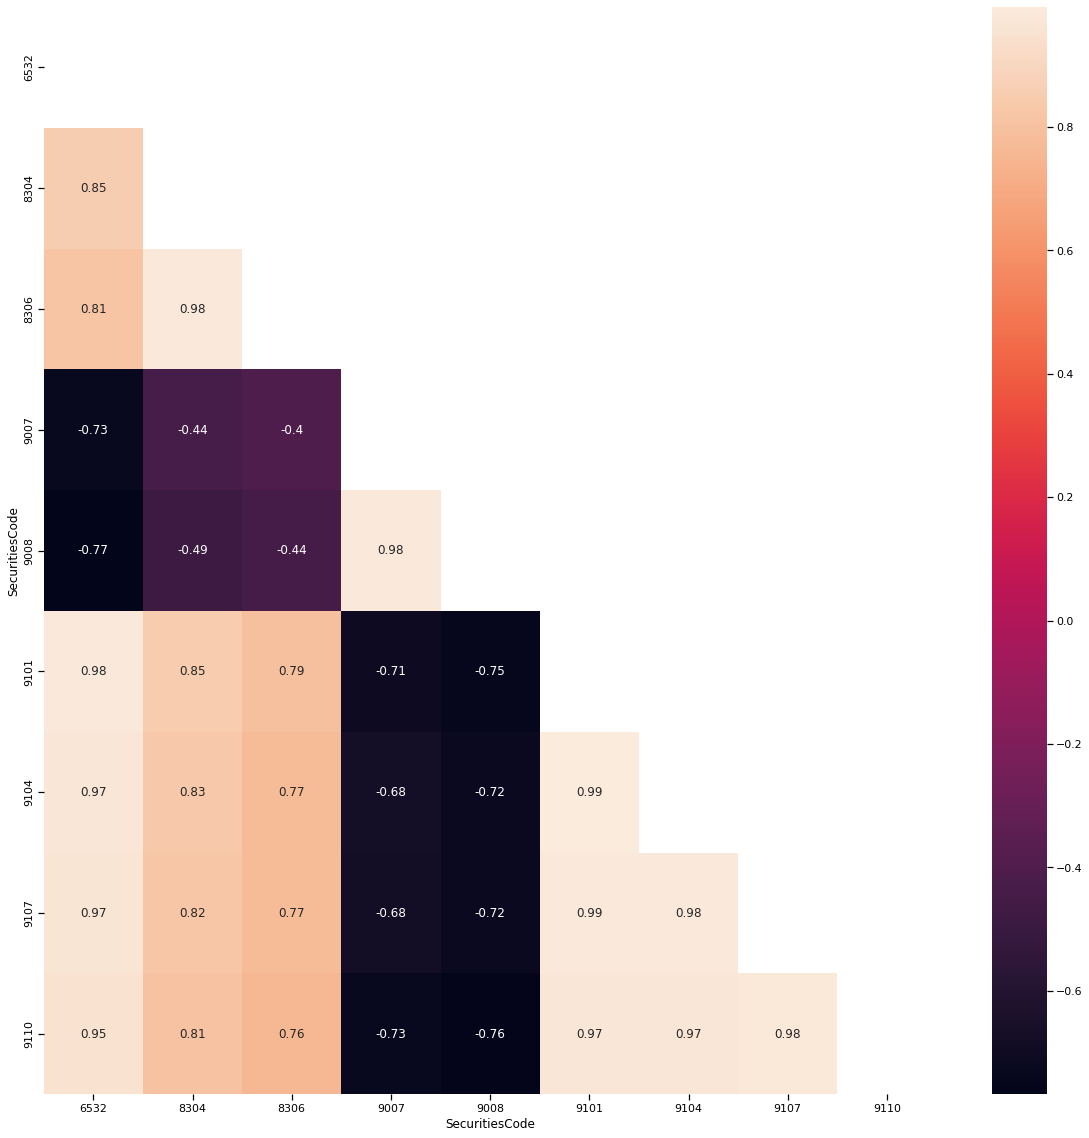

In [6]:
mat = absHighPass(corr,0.98)
mask = np.triu(np.ones_like(mat))
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(mat, annot=True, mask=mask)
plt.show()

### Pair with high correlation

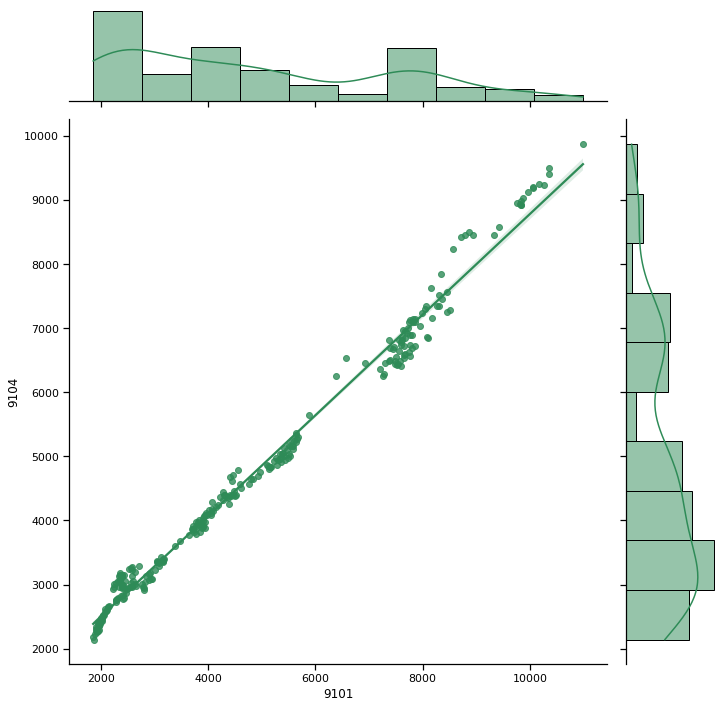

In [7]:
sns.jointplot(9101, 9104, df, kind='reg', color='seagreen', height=10);

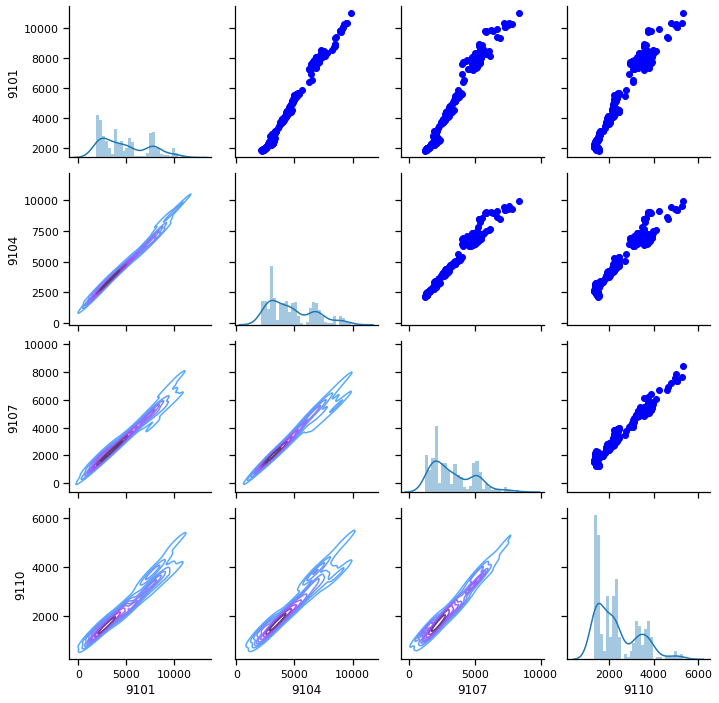

In [8]:
fig = sns.PairGrid(df[[9101, 9104, 9107, 9110]].dropna())
fig.map_upper(plt.scatter, color='blue')
fig.map_lower(sns.kdeplot, cmap='cool_d')
fig.map_diag(sns.distplot, bins=30);

## Stock Charts 

In [9]:
Code = 9101 # Select Security Code

In [10]:
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SecuritiesCode', 'Target']
STOCK = df_train[df_train.SecuritiesCode==Code][cols].set_index("Date")
TEST = df_test[df_test.SecuritiesCode==Code].set_index("Date")
display_html(STOCK)

,Open,High,Low,Close,Volume,SecuritiesCode,Target
Date,,,,,,,
2020-10-05,1863.0,1898.0,1856.0,1872.0,1439600.0,9101,0.013470
2020-10-06,1892.0,1894.0,1846.0,1856.0,1634300.0,9101,0.023392
2020-10-07,1850.0,1889.0,1841.0,1881.0,1548400.0,9101,0.019740
2020-10-08,1921.0,1950.0,1918.0,1925.0,2226000.0,9101,-0.011717
2020-10-09,1934.0,1968.0,1931.0,1963.0,1868400.0,9101,-0.002577
...,...,...,...,...,...,...,...
2021-11-29,7270.0,7710.0,7270.0,7550.0,6589500.0,9101,0.025676
2021-11-30,7650.0,7670.0,7400.0,7400.0,5593800.0,9101,0.052701
2021-12-01,7540.0,7670.0,7390.0,7590.0,5099900.0,9101,0.021277


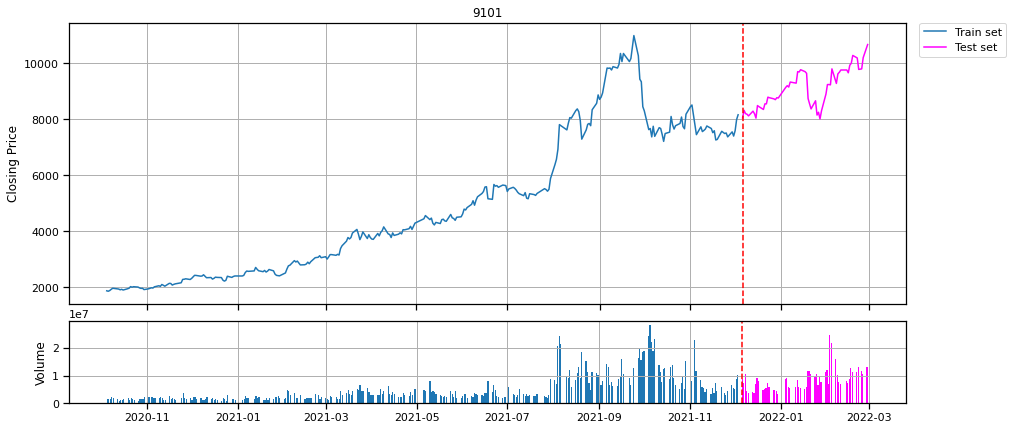

In [11]:
plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(STOCK.index, STOCK.Close, label="Train set")
top.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
bottom.bar(STOCK.index, STOCK.Volume)
bottom.bar(TEST.index, TEST.Volume, color="magenta")
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
 
# set the labels
top.axes.xaxis.set_ticklabels([])
top.axvline(TEST.index[0], color='red', linestyle='--')
bottom.axvline(TEST.index[0], color='red', linestyle='--')
top.set_title(Code)
top.grid(True)
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')
bottom.grid(True);

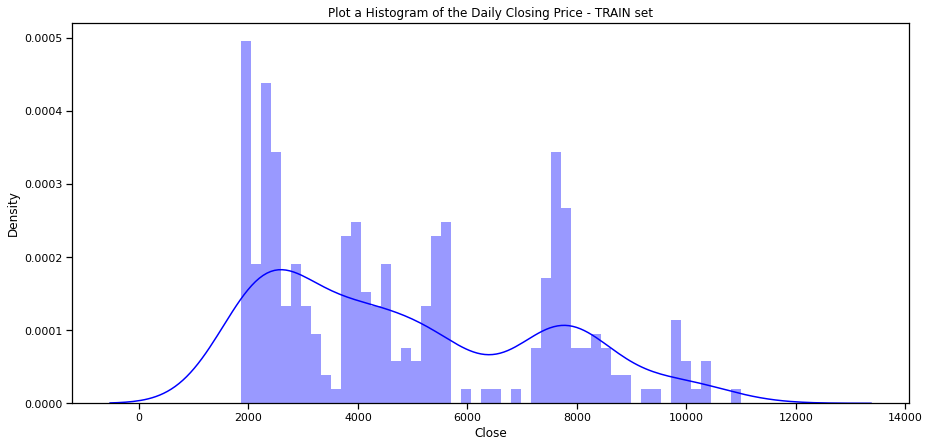

In [12]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TRAIN set")
sns.distplot(STOCK['Close'].dropna(), bins=50, color='blue');

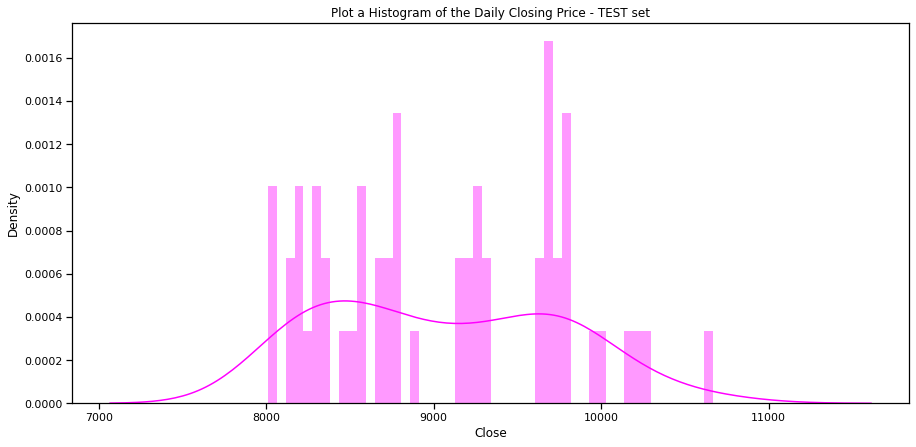

In [13]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TEST set")
sns.distplot(TEST['Close'].dropna(), bins=50, color='magenta');

# Forecast stock price

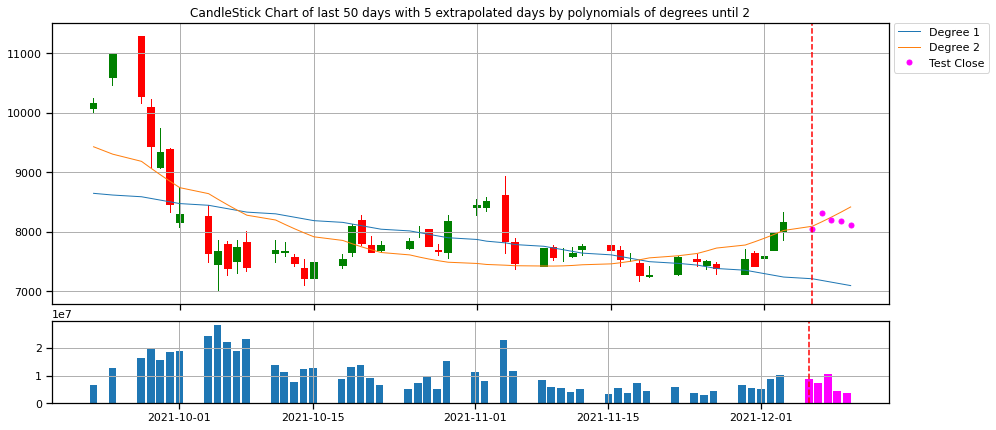

In [14]:
d = 50 # days to plot
e = 5  # days to extrapolate
g = 2  # max degree of regression

width = .8
width2 = .1
col1 = 'green'
col2 = 'red'

LDAYS = STOCK.tail(d)
up = LDAYS[LDAYS.Close>=LDAYS.Open]
down = LDAYS[LDAYS.Close<LDAYS.Open]
fut = TEST[TEST.index<=TEST.head(e).index[-1]]

xd = (LDAYS.index).append(TEST.head(e).index)

x = [x for x in range(d)]
p = {}
for i in range(g):
    z = np.polyfit(x, LDAYS.Close, i+1)
    p[i] = np.poly1d(z)
x = np.array(range(d+e))

plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.set_title(f"CandleStick Chart of last {d} days with {e} extrapolated days by polynomials of degrees until {g}")
top.axes.xaxis.set_ticklabels([])
for i in range(g):
    top.plot(xd, p[i](x), linewidth=1, label=f'Degree {i+1}')
top.plot(fut.index,fut.Close,  marker="o", markersize=5, color="magenta", linewidth=0, label="Test Close")
top.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
top.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
top.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)
top.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
top.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
top.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
top.axvline(TEST.index[0], color='red', linestyle='--')
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
top.grid(True)

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(xd, np.append(LDAYS['Volume'].values,np.zeros(e))) 
bottom.bar(fut.index, fut.Volume, color="magenta") 
bottom.axvline(TEST.index[0], color='red', linestyle='--')

bottom.grid(True)
plt.show();

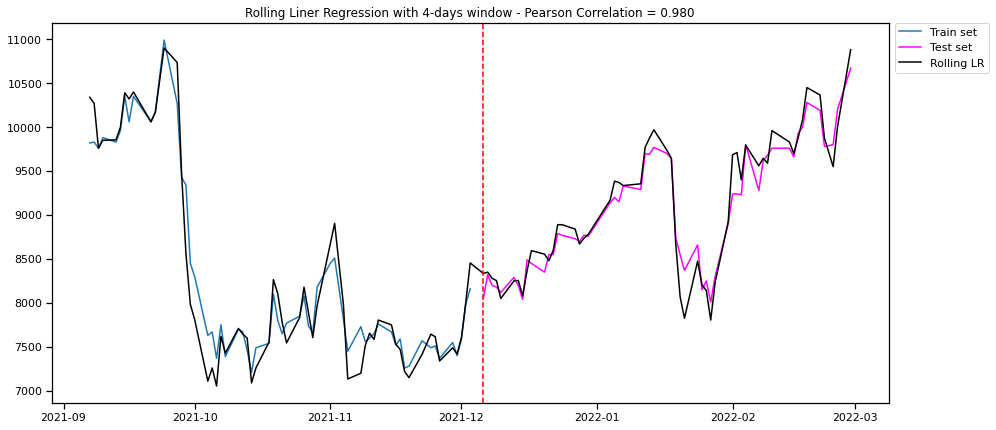

In [15]:
d = 60 # days to plot
w = 4 # windows size

LDAYS = STOCK.tail(d)
fut = pd.concat([STOCK,TEST])
xd = (LDAYS.index).append(TEST.index)

fut['Cl_lr'] = fut.Close.rolling(window=w).apply(lambda y: 
                   np.poly1d(np.polyfit(np.array(range(w)),y,1))(w),raw=True)

fut['Cl2'] = fut.Close.rolling(window=2).apply(lambda y: 
                   np.poly1d(np.polyfit([0,1],y,1))(2),raw=True)

rho = np.corrcoef(fut.Close[-len(xd):],fut.Cl_lr[-len(xd):])

plt.figure(figsize=(15,7))
plt.plot(LDAYS.index, LDAYS.Close, label="Train set")
plt.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
plt.plot(xd,fut.Cl_lr[-len(xd):], color="black", label="Rolling LR")
plt.axvline(TEST.index[0], color='red', linestyle='--')
plt.title(f"Rolling Liner Regression with {w}-days window - Pearson Correlation = {rho[0,1]:.3f}")
plt.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
plt.show();

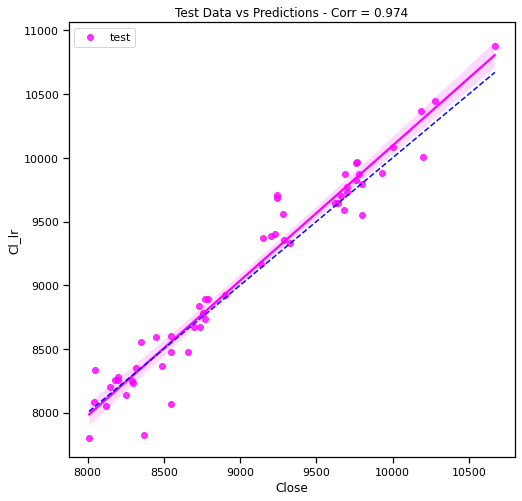

In [16]:
# Generate diagonal line to plot.
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=TEST.Close.min() - 1, stop=TEST.Close.max() + 1, num=100)
sns.regplot(x=TEST.Close, y=fut.Cl_lr[-len(TEST):], color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.set(title=f'Test Data vs Predictions - Corr = {np.corrcoef(TEST.Close,fut.Cl_lr[-len(TEST):])[0,1]:.3f}');

## Prophet Forecasting

In [17]:
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df

year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
holidays = make_holidays_df(year_list=year_list, country='JP')

ph_df = fut[["Close","Cl_lr",'Cl2']][w:len(STOCK)].reset_index()
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

m = Prophet(holidays=holidays,
            daily_seasonality=False,
            changepoint_prior_scale=0.01)
m.add_regressor('Cl_lr')
m.add_regressor('Cl2')
m.fit(ph_df)

Initial log joint probability = -3.26381


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1115.47    0.00525818       3697.04           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       1125.67   0.000179921        737.93    2.03e-07       0.001      216  LS failed, Hessian reset 
     199       1136.22    0.00287722       1437.19     0.09828      0.3988      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1148.54    0.00117315       695.003      0.9619      0.9619      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356        1150.5   1.90112e-07       290.861   7.081e-10       0.001      535  LS failed, Hessian reset 
     392       1150.54   2.74049e-05       351.149   9.684e-08       0.001      631  LS failed, Hessian reset 
     399       1150.54   7.39341e-06  

### Compare Predict and Future Close

In [18]:
# Predict Prices
future_prices = m.make_future_dataframe(periods=87, freq='d')
future_prices = future_prices[future_prices.ds.dt.dayofweek < 5]
future_prices = future_prices.set_index("ds").join(fut[['Cl_lr','Cl2']][w:], how='left')
future_prices = future_prices.reset_index().dropna()
forecast = m.predict(future_prices)
result = TEST[['Close']].join(forecast[['ds','yhat','yhat_lower','yhat_upper']].set_index("ds"),how='left')
display_html(result)

,Close,yhat,yhat_lower,yhat_upper
Date,,,,
2021-12-06,8050.0,8248.013085,8095.258826,8395.874573
2021-12-07,8320.0,8453.964775,8307.802809,8595.207516
2021-12-08,8200.0,8264.869658,8131.540542,8410.967875
2021-12-09,8180.0,8285.384545,8136.529251,8427.167324
2021-12-10,8120.0,8124.451602,7994.637189,8277.514706
2021-12-13,8290.0,8365.736143,8223.424564,8507.464326
2021-12-14,8200.0,8251.997170,8109.156041,8402.668984
2021-12-15,8040.0,8083.779022,7943.628729,8227.267099
2021-12-16,8490.0,8608.728534,8452.819100,8745.145852


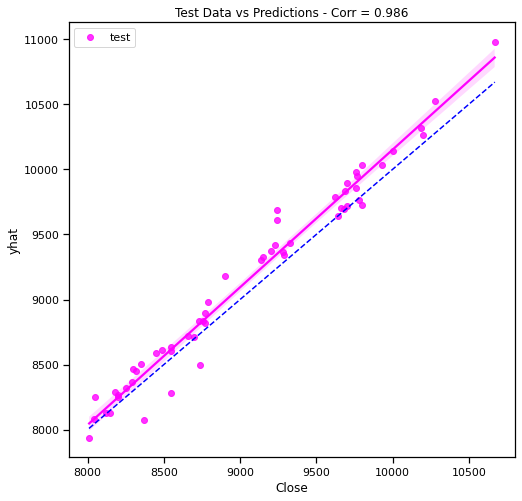

In [19]:
# Generate diagonal line to plot.
rho = np.corrcoef(result.Close,result.yhat)
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=TEST.Close.min() - 1, stop=TEST.Close.max() + 1, num=100)
sns.regplot(x=result.Close, y=result.yhat, color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.legend()
ax.set(title=f'Test Data vs Predictions - Corr = {np.corrcoef(result.Close,result.yhat)[0,1]:.3f}');

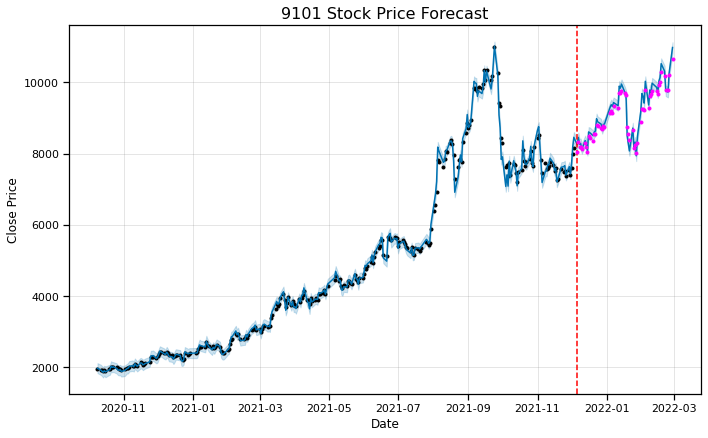

In [20]:
fig = m.plot(forecast)
plt.title(f"{Code} Stock Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.axvline(TEST.index[0], color='red', linestyle='--')
plt.plot(TEST.index, TEST.Close,  marker="o", markersize=3, color="magenta", linewidth=0, label="Test Close")
plt.show()

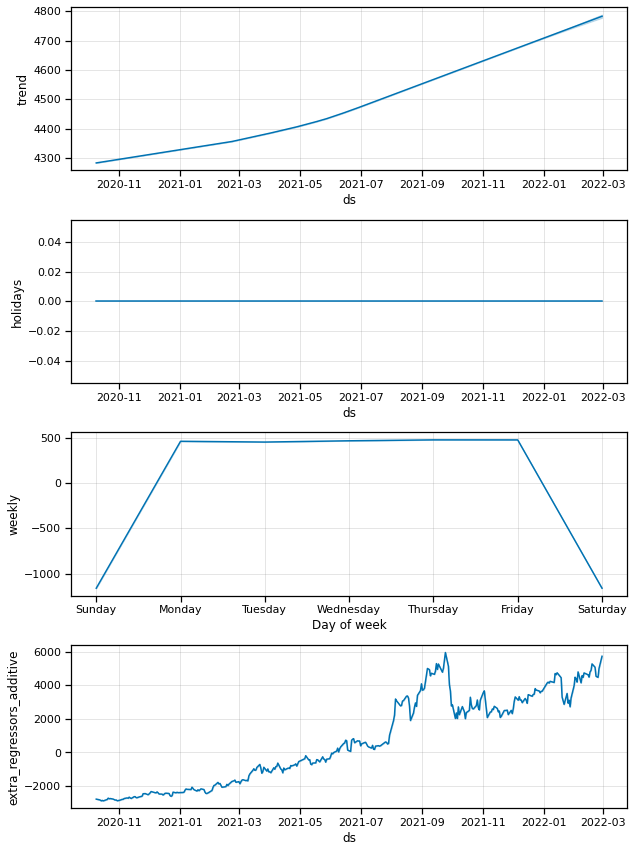

In [21]:
fig2 = m.plot_components(forecast)
plt.show()

In [22]:
# Utilitys
def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def rank(df):
    df.loc[:,"Rank"] = df.groupby("Date")["Target"].rank(ascending=False, method="first") - 1 
    df.loc[:,"Rank"] = df["Rank"].astype("int")
    return df

### Rolling Traning and Predict

In [23]:
def add_feat(df):
    df['C6'] = df.Close.rolling(window=6).apply(lambda y: 
               np.poly1d(np.polyfit(np.array(range(6)),y,1))(6),raw=True)
    df['C3'] = df.Close.rolling(window=3).apply(lambda y: 
               np.poly1d(np.polyfit([0,1,2],y,1))(3),raw=True)
    df['C2'] = df.Close.rolling(window=2).apply(lambda y: 
               np.poly1d(np.polyfit([0,1],y,1))(2),raw=True)
    return df

def run_prophet(tr):
    m = Prophet(holidays=holidays,
                daily_seasonality=False,
                yearly_seasonality=False,
                weekly_seasonality=False,
                changepoint_prior_scale=0.01)
    m.add_regressor('C6')
    m.add_regressor('C2')
    m.fit(tr)
    pred = m.predict(tr[-2:])
    return (pred.yhat[1]/pred.yhat[0] - 1)

def run_reg(tr):
    pred = list(0.5*tr.C2[-2:]+0.3*tr.C3[-2:]+0.2*tr.C6[-2:])
    return (pred[1]/pred[0] - 1)

def proc_cod(cod, tr):
    tr = tr[tr.SecuritiesCode==cod][["Date","Close"]]
    x = [0,1]
    for _ in x:
        tr = tr.append(
        pd.DataFrame({'Date': pd.date_range(start=tr.Date.iloc[-1], 
                                            periods=2, freq='B', 
                                            closed='right'),
                      'Close': np.poly1d(np.polyfit(x,tr.Close[-2:],1))(2)
                     })
        )
    tr = add_feat(tr)
    tr = tr[6:]
    target = run_reg(tr)
    return target

In [24]:
%%time
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

trgts = {}
for (prices, _, _, _, _, sample_prediction) in iter_test:
    cur_date = prices.Date.iat[0]
    cods = prices.SecuritiesCode.unique()
    df_train = pd.concat([df_train, prices])
    df_train = df_train.sort_values(["SecuritiesCode", "Date"])
    df_train.ffill(inplace=True)
    for cod in tqdm(cods):
        trgts[cod] = proc_cod(cod, df_train)
    tr = df_train[df_train.Date==cur_date].copy()
    tr.Target=tr["SecuritiesCode"].map(trgts) 
    tr = rank(tr)
    pred = tr.set_index("SecuritiesCode")["Rank"]
    sample_prediction['Rank'] = sample_prediction["SecuritiesCode"].map(pred)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 6min 33s, sys: 5.32 s, total: 6min 38s
Wall time: 6min 32s
